In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA


## Preprocessing Data

In [19]:
df = pd.read_csv("../data/processed/weatherQN_2021_2025_processed.csv", parse_dates=["time"])

df.head()

,time,temp,dwpt,rhum,prcp,wdir,wspd,pres,coco
0,2021-01-02 00:00:00,20.0,17.4,85.0,0.0,350.0,20.2,1017.9,1.0
1,2021-01-02 03:00:00,20.0,17.8,87.0,0.2,343.0,17.6,1016.1,1.0
2,2021-01-02 06:00:00,19.8,17.8,88.0,0.1,339.0,17.6,1016.7,1.0
3,2021-01-02 09:00:00,20.2,18.3,89.0,0.2,347.0,18.7,1018.4,1.0
4,2021-01-02 12:00:00,22.0,18.0,78.0,0.1,3.0,28.4,1016.4,1.0


In [20]:
df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour
df['day'] = df['time'].dt.day
df["day_of_week"] = df['time'].dt.dayofweek
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df.drop(columns='time', inplace=True)

In [21]:
X = df.drop(columns=['coco'], axis = 1) 
y = df['coco'] 

apply PCA to see if the data is separable 

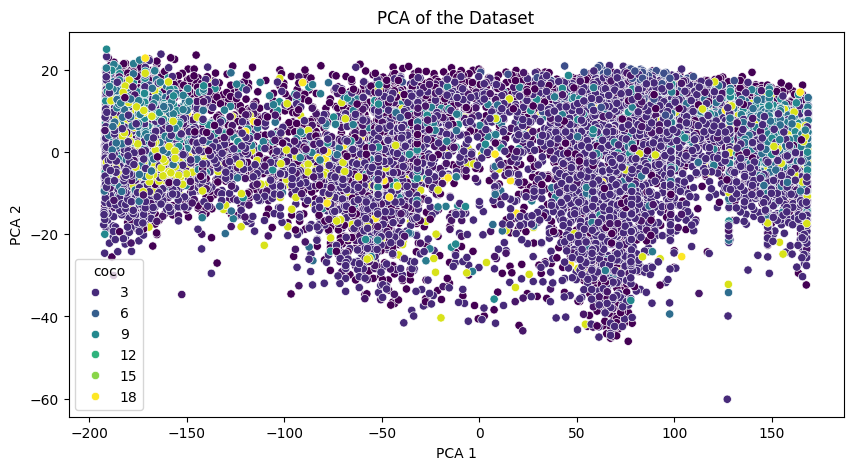

In [22]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(10, 5))
sns.scatterplot(x = X_pca[:, 0], y = X_pca[:, 1], hue = y, palette='viridis')
plt.title('PCA of the Dataset')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [23]:
y.unique()

array([ 1.,  3.,  2.,  7., 17.,  8.,  9., 18.,  5.])

In [24]:
coco_to_weather = {
    1 : 'Clear',
    2 : 'Fair',
    3 : 'Cloudy',
    5 : 'Fog',
    7 : 'Light Rain',
    8 : 'Rain',
    9 : 'Heavy Rain',
    17 : 'Rain Shower',
    18 : 'Heavy Rain Shower'
}

C:\Users\admin\AppData\Local\Temp\ipykernel_28224\2024547877.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = label_counts.values,


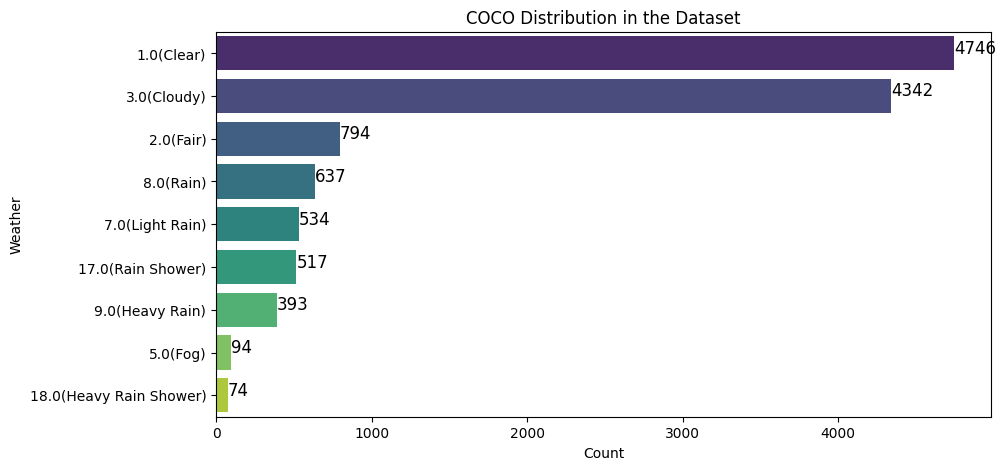

In [25]:
label_counts = y.value_counts().sort_index()
label_counts = label_counts.sort_values(ascending = False)

plt.figure(figsize=(10, 5))
sns.barplot(x = label_counts.values,
            y = [f"{i}({coco_to_weather[i]})" for i in label_counts.index],
            palette='viridis')
for i in range(len(label_counts)):
    plt.text(label_counts.values[i], i, label_counts.values[i], fontsize = 12)
plt.title('COCO Distribution in the Dataset') 
plt.xlabel('Count')
plt.ylabel('Weather')
plt.show()

re-index the label for easy to use in models

In [26]:
# re-indexing the labels
coco_to_index = {coco : i for i, coco in enumerate(y.unique())}
index_to_coco = {i : coco for coco, i in coco_to_index.items()}

y = y.map(coco_to_index)
y

0        0
1        0
2        0
3        0
4        0
        ..
12126    1
12127    0
12128    0
12129    1
12130    8
Name: coco, Length: 12131, dtype: int64

Notice that there're a high imballance classification problem, so we decide to use class_weight to penalize the models

In [27]:
class_weights = compute_class_weight(class_weight = "balanced",
                                     classes = np.unique(y),
                                        y = y)
class_weights

array([ 0.28400524,  0.31043042,  1.69759306,  2.5241365 ,  2.60713518,
        2.11599512,  3.42974272, 18.21471471, 14.3392435 ])

scale the features into the same range 
$$
X_{\text{scaled}} = \frac{X - \mu}{\sigma}
$$
which make all features have a mean of 0 and a standard deviation of 1

In [28]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-1.76857525e+00, -2.17431041e+00,  3.39528807e-01, ...,
         9.98930464e-01, -1.50772660e+00, -1.33082598e+00],
       [-1.76857525e+00, -2.00356375e+00,  5.05993017e-01, ...,
         9.98930464e-01, -1.50772660e+00, -1.33082598e+00],
       [-1.82509850e+00, -2.00356375e+00,  5.89225122e-01, ...,
         9.98930464e-01, -1.50772660e+00, -1.33082598e+00],
       ...,
       [-6.94633508e-01,  4.29576127e-01,  1.42154617e+00, ...,
        -4.99218237e-01, -9.39239137e-01,  1.99394362e+00],
       [-7.51156757e-01,  3.44202798e-01,  1.42154617e+00, ...,
         1.64663391e-04, -9.39239137e-01,  1.99394362e+00],
       [-9.77249755e-01,  4.53961469e-02,  1.50477828e+00, ...,
         1.64663391e-04, -9.39239137e-01,  1.99394362e+00]])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9704, 12), (2427, 12), (9704,), (2427,))

In [30]:
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}
sample_weights = y_train.map(class_weights_dict)

sample_weights

3528     0.284005
7028     0.310430
568      0.284005
6929     1.697593
5537     0.310430
           ...   
11964    0.310430
5191     3.429743
5390     0.310430
860      0.284005
7270     2.607135
Name: coco, Length: 9704, dtype: float64

## Building Model

|Instance| Desciption|
|---|---|
|model0| XGBClassifier|
|model1| Support Vector Machine classifier|
|model1| Simple neural network|

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from xgboost import XGBClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [35]:
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt =  "", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

### XGBoost

In [36]:
model0 = XGBClassifier(objective = 'multi:softmax',
                       num_class = 9, 
                       n_estimators = 200,
                       learning_rate = 0.01,
                       max_depth = 20, 
                       n_jobs = -1,
                       random_state = 42)

model0.fit(X_train, y_train,
           sample_weight = sample_weights)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1, num_class=9,
              num_parallel_tree=None, ...)

In [37]:
y_pred0 = model0.predict(X_test)
acc0 = accuracy_score(y_test, y_pred0)
print(f"Accuracy: {acc0:.4f}")
print(classification_report(y_test, y_pred0))

Accuracy: 0.8138
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       953
           1       0.83      0.84      0.83       863
           2       0.27      0.36      0.31       162
           3       0.69      0.77      0.73       109
           4       0.51      0.38      0.43        92
           5       0.86      0.93      0.89       128
           6       0.85      0.92      0.88        77
           7       0.54      0.39      0.45        18
           8       0.46      0.52      0.49        25

    accuracy                           0.81      2427
   macro avg       0.66      0.67      0.66      2427
weighted avg       0.83      0.81      0.82      2427



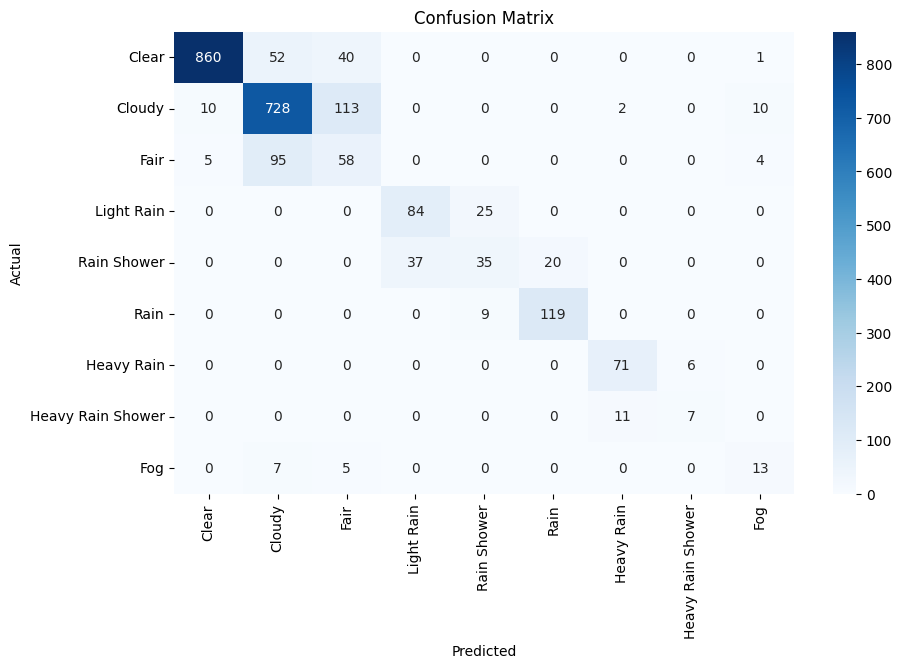

In [38]:
plot_confusion_matrix(y_test, y_pred0, [coco_to_weather[index_to_coco[i]] for i in range(9)])

### Support Vector Machine

In [ ]:
model1 = SVC(kernel = 'rbf', 
             C = 1, 
             gamma = 0.1, 
             class_weight = 'balanced')

model1.fit(X_train, y_train)

SVC(C=1, class_weight='balanced', gamma=0.1)

In [40]:
y_pred1 = model1.predict(X_test)
acc1 = accuracy_score(y_test, y_pred1)
print(f"Accuracy: {acc1:.4f}")
print(classification_report(y_test, y_pred1))

Accuracy: 0.6918
              precision    recall  f1-score   support

           0       0.98      0.88      0.92       953
           1       0.82      0.52      0.64       863
           2       0.23      0.60      0.34       162
           3       0.35      0.67      0.46       109
           4       0.36      0.42      0.39        92
           5       0.78      0.68      0.73       128
           6       0.78      0.84      0.81        77
           7       0.53      0.56      0.54        18
           8       0.28      0.80      0.42        25

    accuracy                           0.69      2427
   macro avg       0.57      0.66      0.58      2427
weighted avg       0.79      0.69      0.72      2427



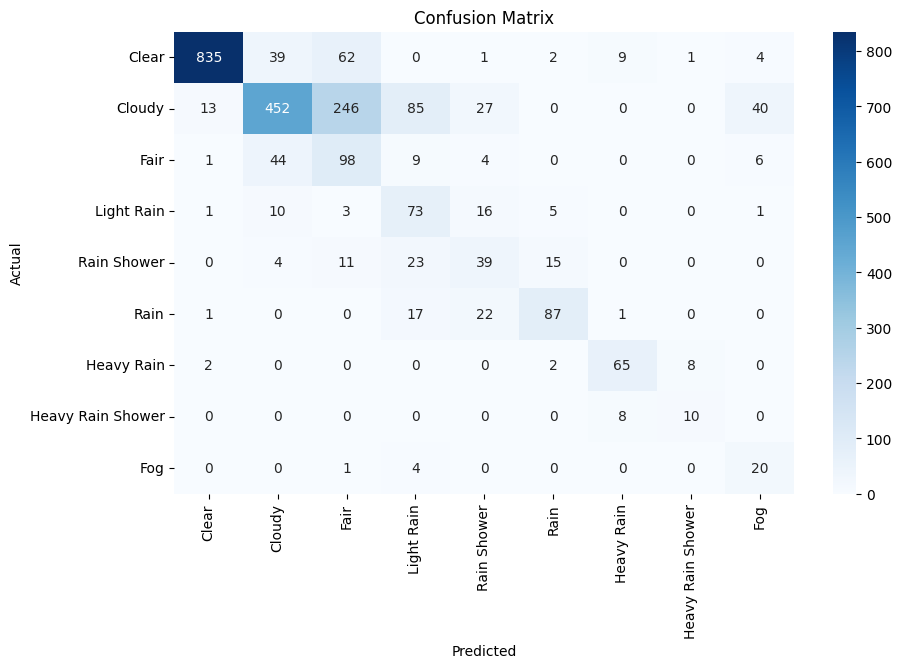

In [41]:
plot_confusion_matrix(y_test, y_pred1, [coco_to_weather[index_to_coco[i]] for i in range(9)])

### Neural Network

In [42]:
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out
    
input_dim = X_train.shape[1]
output_dim = len(y.unique())
hidden_dim = 32

model2 = NeuralNet(input_dim, output_dim, hidden_dim).to(device)
model2


NeuralNet(
  (fc1): Linear(in_features=12, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=9, bias=True)
  (relu): ReLU()
)

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = 0.01)

X_train_tensor = torch.tensor(X_train, dtype = torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype = torch.long).to(device)

X_test_tensor = torch.tensor(X_test, dtype = torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype = torch.long).to(device)

In [44]:
EPOCHS = 100

for epoch in range(EPOCHS):
    optimizer.zero_grad()
    y_pred = model2(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} Loss: {loss.item()}")

Epoch: 0 Loss: 2.197134017944336
Epoch: 10 Loss: 1.38496994972229
Epoch: 20 Loss: 1.0669243335723877
Epoch: 30 Loss: 0.9417396783828735
Epoch: 40 Loss: 0.8304140567779541
Epoch: 50 Loss: 0.7422506213188171
Epoch: 60 Loss: 0.664223313331604
Epoch: 70 Loss: 0.6008715629577637
Epoch: 80 Loss: 0.5525307655334473
Epoch: 90 Loss: 0.5167096853256226


In [45]:
y_pred2 = model2(X_test_tensor)
_, y_pred2 = torch.max(y_pred2, 1)
y_pred2 = y_pred2.cpu().numpy()

acc2 = accuracy_score(y_test, y_pred2)
print(f"Accuracy: {acc2:.4f}")
print(classification_report(y_test, y_pred2))

Accuracy: 0.8216
              precision    recall  f1-score   support

           0       0.98      0.90      0.94       953
           1       0.73      0.99      0.84       863
           2       0.00      0.00      0.00       162
           3       0.76      0.51      0.61       109
           4       0.51      0.45      0.48        92
           5       0.80      0.89      0.84       128
           6       0.77      0.97      0.86        77
           7       1.00      0.06      0.11        18
           8       0.00      0.00      0.00        25

    accuracy                           0.82      2427
   macro avg       0.62      0.53      0.52      2427
weighted avg       0.77      0.82      0.79      2427



c:\Users\admin\anaconda3\envs\wf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\wf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\admin\anaconda3\envs\wf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


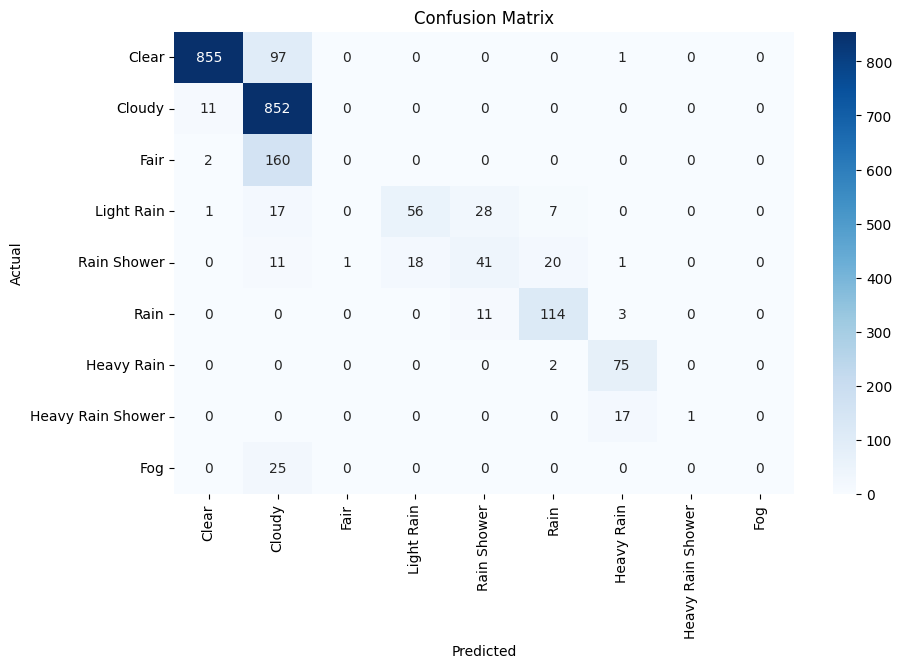

In [46]:
plot_confusion_matrix(y_test, y_pred2, [coco_to_weather[index_to_coco[i]] for i in range(9)])

## Benchmark

C:\Users\admin\AppData\Local\Temp\ipykernel_28224\1917041268.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = acc_list, y = models, palette='viridis')


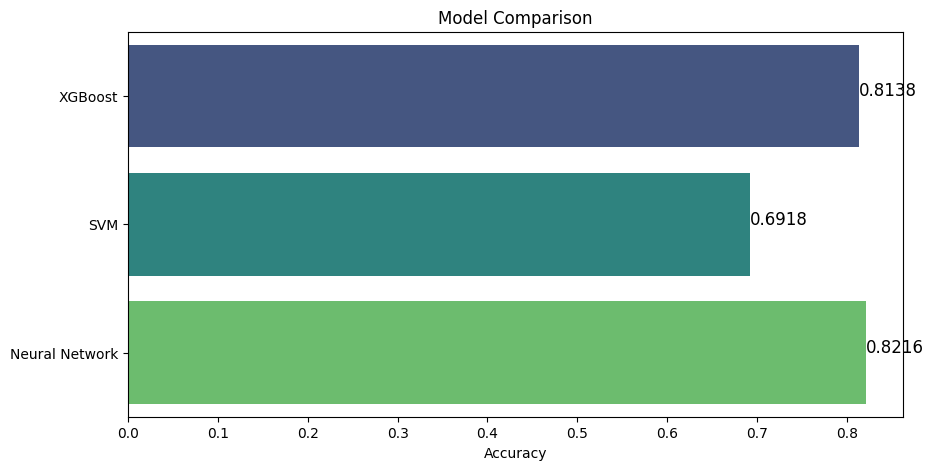

In [47]:
acc_list = [acc0, acc1, acc2]
models = ['XGBoost', 'SVM', 'Neural Network']

plt.figure(figsize=(10, 5))
sns.barplot(x = acc_list, y = models, palette='viridis')
for i in range(len(acc_list)):
    plt.text(acc_list[i], i, f"{acc_list[i]:.4f}", fontsize = 12)
plt.title('Model Comparison')
plt.xlabel('Accuracy')

plt.show()

Although getting the higher accuracy, the Neural Network can't predict any `'Fog'` and `'Fair'` weather, which is not acceptable. The XGBoost model is the best model for this dataset. The XGBoost model has a bit lower accuracy, but it can predict all the classes.

In [48]:
# save best model
model0.save_model('../models/best_cls_model/xgboost_model.json')